In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**다양한 분류기 만드는 방법**

1) 같은 데이터 셋에 대해 각기 다른 훈련 알고리즘을 사용하는 방법

2) 데이터 셋의 서브셋을 무작위로 구정해서 같은 알고리즘을 각기 다르게 학습시키는 방법

#7.1 투표 기반 분류기

방법 1) 같은 데이터 셋에 대해 각기 다른 훈련 알고리즘을 사용하는 방법

###직접 투표

- 각기 다른 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 방법..
- **큰 수의 법칙**에 의해서 각 분류기가 약하더라도 충분히 많고 다양하다면 앙상블은 강해진다..

앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘함..

In [ ]:
#moons 데이터셋 준비

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
from sklearn.ensemble import VotingClassifier   #투표기반 분류기
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC     #predict_proba() 함수 없음..

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

#3가지 분류기로 분류해서 젤 많이 예측된 클래스로 최종 예측
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'   #직접 투표
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [ ]:
# 각 분류기 정확도 예측..

from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))   #이름과 점수 출력

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.904


**분석**

- 투표기반 분류기가 다른 개별 분류기보다 더 성능이 높다!!

###간접 투표

- 모든 분류기가 클래스의 확률을 예측할 수 있으면 가능..
- 개별 분류기의 예측을 평균내서 확률이 가장 높은 클래스를 예측한다..
- predict_proba() 메서드가 있어야 가능..

In [ ]:
#SVC가 원래 없는데, probability 매개변수를 True로 두면 속도는 좀 느려도(교차검증) 가능하다..

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC(probability=True)

#3가지 분류기로 분류해서 젤 많이 예측된 클래스로 최종 예측
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'   #간접 투표
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [ ]:
#간접투표 정확도..

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.92


#7.2 배깅과 페이스팅

방법 2) 데이터 셋의 서브셋을 무작위로 구정해서 같은 알고리즘을 각기 다르게 학습시키는 방법



- 각 예측기마다 훈련에 사용할 샘플을 무작위로 골라야한다...
- 배깅 : **복원 추출**  /  페이스팅 : **비복원 추출**
- 둘 다 **한 예측기를 위한 샘플을 뽑을 때**를 이야기하는 것..
- 전반적으로는 배깅이 더 나은 모델을 만듦
- 이렇게 뽑아서 모든 예측기가 훈련을 다 하면 그 예측들을 다 모아서 사용한다
- 모으는 게 **수집 함수**이다
    - 분류일 때는 **통계적 최빈값**, 회귀일 때는 **평균**
- 각각의 예측기는 전체 훈련세트로 훈련한 거보다 크게 편향되어 있지만, 수집함수를 통과하면 편향, 분산 모두 감소한다

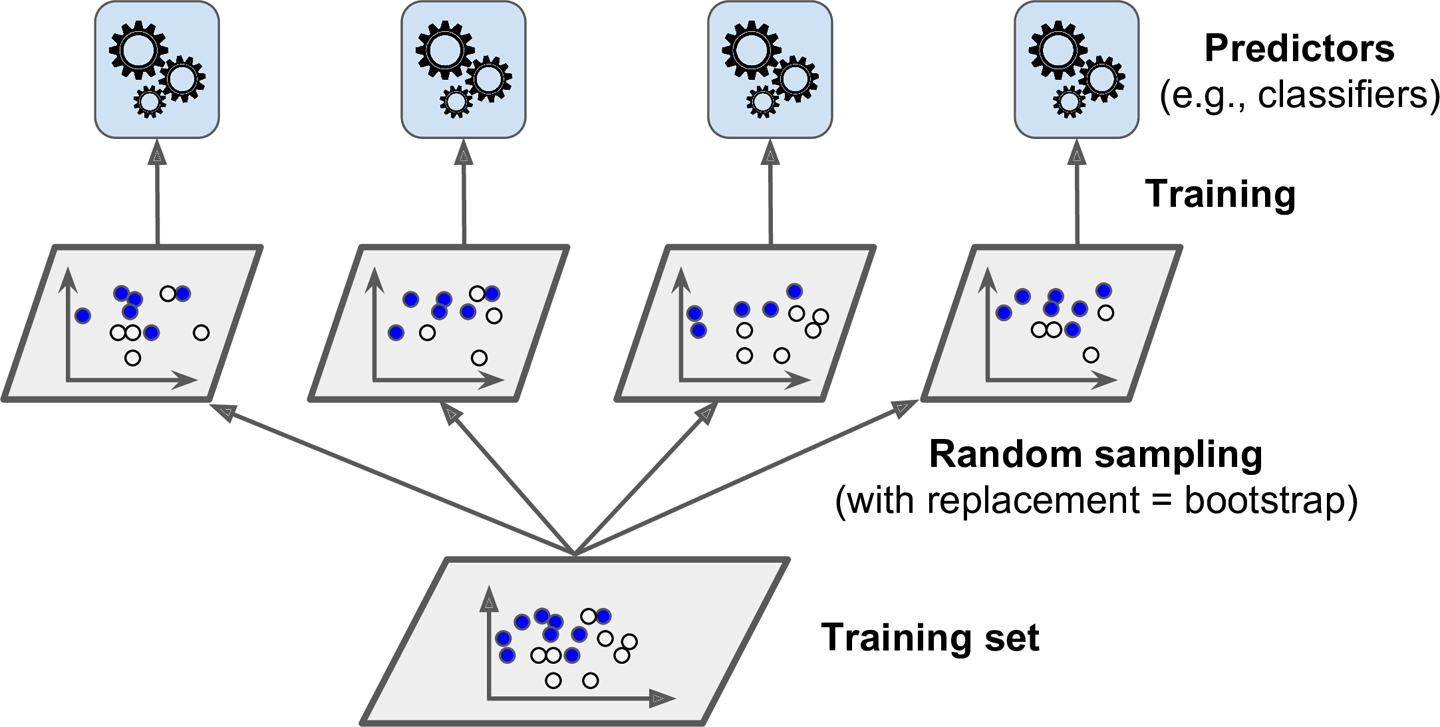

##7.2.1 사이킷런의 배깅과 페이스팅

**매개변수**

- n_estimators : 500개의 결정트리를 앙상블 하겠다
- max_samples : 100개의 샘플을 뽑아서 개별 분류기의 훈련에 사용하겠다
- bootstrap : True이면 배깅, False이면 페이스팅

In [ ]:
#배깅 앙상블 구현

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
#그냥 결정트리 한개..

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

In [ ]:
#점수 확인.. 앙상블이 더 높다!!

print(f"앙상블 시 점수는 {accuracy_score(y_test, y_pred)}입니다")
print(f"결정트리 하나의 점수는 {accuracy_score(y_test, y_pred_tree)}입니다")

앙상블 시 점수는 0.912입니다
결정트리 하나의 점수는 0.856입니다


In [ ]:
#결정경계 그리는 함수..

from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

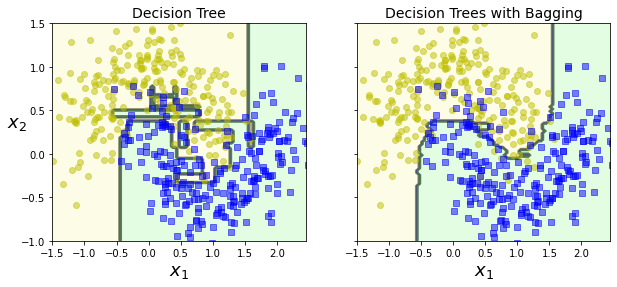

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

#결정트리 한개
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

#앙상블
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

plt.show()

**분석**

- 배깅을 사용한 오른쪽이 훨씬 일반화가 잘 됨
- 비슷한 편향(훈련 세트의 오차 수는 비슷)에서 더 작은 분산(결정경계가 덜 불규칙)을 만든다

##7.2.2 oob 평가

- 배깅 사용시 훈련에 사용되지 않는 샘플들을 **oob 샘플**이라고 함
- 평균적으로 $37\%$정도 남겨진다
- **검증 세트 대용으로 oob 샘플 사용**
- oob_score매개변수를 True로 주면 자동으로 훈련 끝난 뒤 oob 평가를 수행함..

In [ ]:
#oob_score=True로 지정

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

#테스트 세트에서 약 90퍼센트 정확도 예측...

0.9013333333333333

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

- oob 샘플에 대한 결정함수 값도 oob_decision_funciton_ 변수에서 확인 가능
     - predict_proba()메서드를 가지는 예측기이기 때문

In [ ]:
bag_clf.oob_decision_function_

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08379888, 0.91620112],
       [0.31693989, 0.68306011],
       [0.02923977, 0.97076023],
       [0.97687861, 0.02312139],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.71195652, 0.28804348],
       [0.83957219, 0.16042781],
       [0.97777778, 0.02222222],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97297297, 0.02702703],
       [0.95238095, 0.04761905],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.38947368, 0.61052632],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.96685083, 0.03314917],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.64804469, 0.35195531],
       [0.

In [ ]:
#375개의 oob샘플들.. 2는 [음성, 양성]클래스

bag_clf.oob_decision_function_.shape

(375, 2)

#7.3 랜덤 패치와 랜덤 서브스페이스

- 특성도 랜덤으로 뽑는다..
- 각 예측기가 무작위로 선택한 입력특성의 일부분으로 훈련됨
- 이미지와 같은 고차원의 데이터셋을 다룰 때 유용함
- 특성 샘플링은 더 다양한 예측기를 만들고, 편향을 늘리지만 분산은 낮춘다

**랜덤 패치 방식**

- 특성과 샘플을 모두 샘플링하는 방식

**랜덤 서브스페이스 방식**
- 샘플을 다 쓰고 특성만 샘플링하는 방식

#7.4 랜덤 포레스트

- BaggingClassifier의 매개변수를 모두 가지고 있고, 결정트리의 성장을 제한할 수 있다
- 트리의 노드를 분할할 때 **선택한 특성 후보 중에서 최적의 특성을 찾음**
- 무작위성이 더 커짐..
    - 편향을 손해보지만, 분산을 낮춤..


In [ ]:
#랜덤 포레스트 모델 이용..
#max_features매개변수의 기본값은 "auto"이고, "sqrt"와 같다..
#루트 특성개 만큼 중에서 최적의 특성을 찾아내겠다는 말이다

from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [ ]:
#배깅으로 만들어 봄..
#max_samples가 float형이면 비율을 나타냄..

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42
)
bag_clf.fit(X_train, y_train)

y_pred_bag = bag_clf.predict(X_test)

In [ ]:
# 두 방법(배깅, 랜덤포레스트)의 예측 비교.. 똑같다..

np.sum(y_pred_bag == y_pred_rf) / len(y_pred)

1.0

##7.4.1 엑스트라 트리

- 후보 특성을 사용해서 무작위로 분할한 다음 그중에서 최상의 분할을 선택함..
- 이런 극단적으로 무작위한 결정트리의 랜덤 포레스트를 **익스트림 랜덤 트리** 혹은 **엑스트라 트리**라고 함
- 이것 역시 편향은 늘어나지만 분산은 낮춤
- 일반적인 랜덤포레스트보다 훨씬 빠름

##7.4.2 특성 중요도

- 랜덤 포레스트는 상대적 특성 중요도를 알기 쉽다
- 어떤 특성을 사용한 노트가 평균적으로 불순도를 얼마나 감소시키는지를 확인해서 중요도를 측정한다
- 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산해서 중요도 전체 합이 1이 되도록 정규화한다..

In [ ]:
#붓꽃 데이터 셋 특성 중요도 확인..

from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


####MNIST 데이터셋의 각 픽셀의 중요도

In [ ]:
#데이터 준비

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [ ]:
#훈련

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
#이미지 하나 그리는 함수

def plot_digit(data):
    image = data.reshape(28,28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

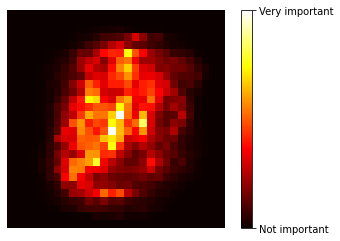

In [ ]:
#특성 중요도를 그리자..
#중간픽셀이 중요하네..

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

#7.5 부스팅

- 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법
- **앞의 모델을 보완해 나가면서 일련의 예측기를 학습시키는 것**
- 에이다 부스트 / 그레이디언트 부스팅이 있음
- 연속된 학습기법은 이전 예측기의 학습 및 평가 후에 다음 학습이 일어남 -> **병렬화 불가능**

##7.5.1 에이다부스트

이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높인다

**훈련 과정**

- 첫 번째 분류기를 훈련 세트로 훈련시키고 예측을 만듦
- 알고리즘이 **잘못 분류된 훈련 샘플의 가중치를 상대적으로 높임**
- 두 번째 분류기는 업데이트된 가중치를 사용해서 다시 훈련하고 예측을 다시 만듦..
- 또 가중치를 조정함..
- 이를 반복..
- 아래 그림의 우하향 화살표가 가중치 업데이트하는 과정임


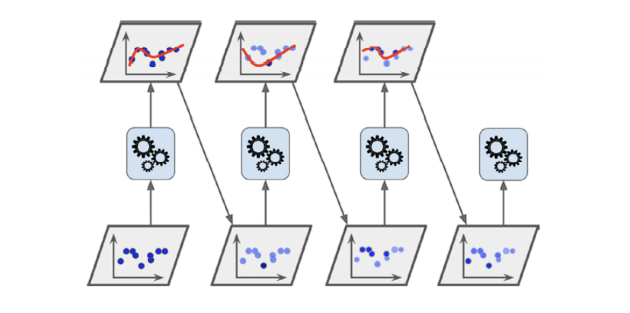

##7.5.2 그레이디언트 부스팅

#7.6 스태킹

#7.7 연습문제